In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from scipy.ndimage.interpolation import shift
import pickle

In [1]:
for i in range(256):
    for j in range(256):
        img[i][j] = (i**2-j**2)

NameError: name 'img' is not defined

In [3]:
img = cv2.imread("images/wolf.png",0)

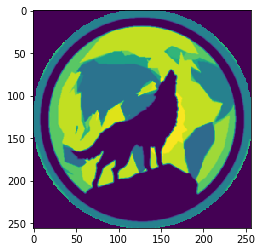

In [4]:
plt.imshow(img)

In [5]:
#dividing into blocks of 16*16
rows = len(img)
cols = len(img[0])

blk_sz_x = 32
blk_sz_y = 32

num_blk_x = rows//blk_sz_x
num_blk_y = cols//blk_sz_y
num_blk = num_blk_x*num_blk_y

In [6]:
#block stores all the puzzle blocks
def divide_image(img,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y):
    blocks = []

    for i in range(num_blk_x):
        for j in range(num_blk_y):
            block = []
            for k in range(blk_sz_x):
                block.append(img[i*blk_sz_x+k][j*blk_sz_y:(j+1)*blk_sz_y])
            blocks.append(np.array(block))
    return blocks

In [7]:
blocks = divide_image(img,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y)

In [8]:
#initializing a random population
def init_population(ppl_sz,num_blk_x,num_blk_y,num_blk):

    population = []

    for i in range(ppl_sz):
        population.append(np.random.permutation(num_blk).reshape(num_blk_x,num_blk_y))

    return population

In [9]:
population = init_population(1000,num_blk_x,num_blk_y,num_blk)

In [10]:
def get_image(specie,blocks):
    img_specie_row = []
    for i in range(num_blk_x):
        row = blocks[specie[i][0]]
        for j in range(1,num_blk_y):
            row = np.concatenate((row,blocks[specie[i][j]]),axis=1)
        img_specie_row.append(row)
        
    img_specie = img_specie_row[0]
    for i in range(1,num_blk_x):
        img_specie = np.concatenate((img_specie,img_specie_row[i]),axis=0)
    return img_specie

In [11]:
def visual_specie(specie, blocks):
    plt.imshow(get_image(specie,blocks))

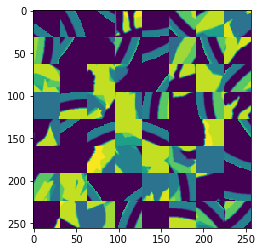

In [12]:
visual_specie(population[0],blocks)
#visual_specie(np.arange(num_blk).reshape(num_blk_x,num_blk_y),blocks)

In [13]:
def compute_cost(specie,blocks,num_blk_x,num_blk_y):
    cost = 0
    for i in range(num_blk_x-1):
        for j in range(num_blk_y-1):
            p = specie[i][j]
            p1 = specie[i+1][j]
            p2 = specie[i][j+1]
            cost += np.sum(abs(blocks[p][-1] - blocks[p1][0]))
            cost += np.sum(abs(blocks[p].T[-1] - blocks[p2].T[0]))
    return cost

In [14]:
#compute_cost(population[0],blocks,num_blk_x,num_blk_y)
compute_cost(np.arange(num_blk).reshape(num_blk_x,num_blk_y),blocks,num_blk_x,num_blk_y)

95271.0

270501.0


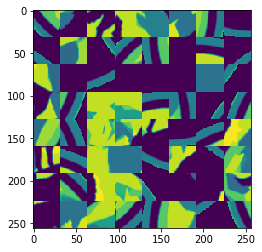

In [15]:
bst = 0
bstcst = compute_cost(population[0],blocks,num_blk_x,num_blk_y)
for i in range(len(population)):
    cost = compute_cost(population[i],blocks,num_blk_x,num_blk_y)
    if cost <= bstcst:
        bst = i
        bstcst = cost
print(bstcst)
visual_specie(population[bst],blocks)

In [16]:
def elite_species(population,blocks,num_blk_x,num_blk_y,elite_pt):
    cost = []
    for member in population:
        cost.append(compute_cost(member,blocks,num_blk_x,num_blk_y))
    zipped_list = zip(cost,population)
    sorted_zipped_list = sorted(zipped_list, key=lambda x: x[0])
    new_population = [element for _, element in sorted_zipped_list]
    
    mid = int(elite_pt*len(population))
    
    return new_population[:mid]

In [17]:
def elite_diversity(elite):
    cost = []
    for i in elite:
        cost.append(compute_cost(i,blocks,num_blk_x,num_blk_y))
    return len(set(cost))

In [18]:
def next_gen(population,blocks,num_blk_x,num_blk_y,ppl_sz):
    cost = []
    for member in population:
        cost.append(compute_cost(member,blocks,num_blk_x,num_blk_y))
    zipped_list = zip(cost,population)
    sorted_zipped_list = sorted(zipped_list,key=lambda x: x[0])
    new_pop = [element for _, element in sorted_zipped_list]
    cost.sort()
    next_pop = [new_pop[0]]
    ind = 1
    while len(next_pop)<int(0.3*ppl_sz) and ind<len(new_pop):
        if cost[ind-1]!=cost[ind]:
            next_pop.append(new_pop[ind])
        ind+=1
    random.shuffle(new_pop)
    next_pop.extend(new_pop[:ppl_sz-len(next_pop)])
    return next_pop

In [19]:
def apply_patch(mat,pch,top,h,w):
    dic = {}
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            dic[mat[i][j]] = (i,j)
            
    m = mat.copy()
    for i in range(h):
        for j in range(w):
            p1 = pch[i][j]
            p2 = m[top[0]+i][top[1]+j]
            lp1 = dic[p1]
            lp2 = dic[p2]
            m[lp1[0]][lp1[1]] = p2
            m[lp2[0]][lp2[1]] = p1
            dic[p1] = lp2
            dic[p2] = lp1
    return m

In [20]:
def crossover1(m1,m2,blocks,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y):
    top = (random.randint(0,num_blk_x-1),random.randint(0,num_blk_y-1))
    bot = (random.randint(top[0],num_blk_x-1),random.randint(top[1],num_blk_y-1))
    h = bot[0]-top[0]+1
    w = bot[1]-top[1]+1
    new_top = (random.randint(0,num_blk_x-h),random.randint(0,num_blk_y-w))
    pt1 = m1[top[0]:bot[0]+1,top[1]:bot[1]+1]
    pt2 = m2[new_top[0]:new_top[0]+h, new_top[1]:new_top[1]+w]
    p1 = apply_patch(m1,pt2,top,h,w)
    p2 = apply_patch(m2,pt1,new_top,h,w)
    return p1,p2

In [21]:
def mutate(m,blocks,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y):
    if(random.random()>0.5):
        x = random.randint(0,num_blk_x)
        return np.append(m[x:],m[:x],axis=0)
    else:
        y = random.randint(0,num_blk_y)
        return np.append(m.T[y:],m.T[:y],axis=0)

In [22]:
def self_mutate(mat,blocks,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y):
    m = mat.copy()
    cell1 = (random.randint(0,num_blk_x-1),random.randint(0,num_blk_y-1))
    cell2 = (random.randint(0,num_blk_x-1),random.randint(0,num_blk_y-1))
    tmp = m[cell1[0]][cell1[1]]
    m[cell1[0]][cell1[1]] = m[cell2[0]][cell2[1]]
    m[cell2[0]][cell2[1]] = tmp
    return m

83840.0


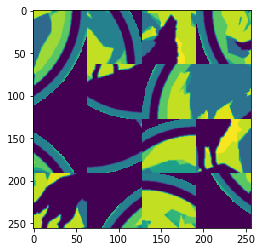

In [29]:
total_gen = 1500
best_specie_gen = []
curr_gen = 0
ppl_sz = 100

rows = len(img)
cols = len(img[0])

blk_sz_x =64
blk_sz_y =64

num_blk_x = rows//blk_sz_x
num_blk_y = cols//blk_sz_y
num_blk = num_blk_x*num_blk_y

elite_pt = 0.05

blocks = divide_image(img,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y)

population = init_population(ppl_sz,num_blk_x,num_blk_y,num_blk)

bst = 0
bstcst = compute_cost(population[0],blocks,num_blk_x,num_blk_y)
for i in range(len(population)):
    cost = compute_cost(population[i],blocks,num_blk_x,num_blk_y)
    if cost <= bstcst:
        bst = i
        bstcst = cost
print(bstcst)
visual_specie(population[bst],blocks)

31152.0

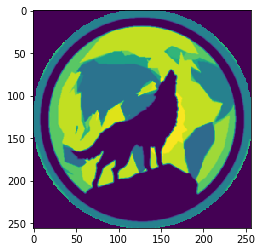

In [30]:
visual_specie(np.arange(num_blk).reshape(num_blk_x,num_blk_y),blocks)
compute_cost(np.arange(num_blk).reshape(num_blk_x,num_blk_y),blocks,num_blk_x,num_blk_y)

In [31]:
for gen in range(curr_gen,total_gen):
    elite = elite_species(population,blocks,num_blk_x,num_blk_y,elite_pt)
    if gen%50==0:
        print("Elite diversity: "+str(elite_diversity(elite)))
    """
    mip = 1000000000
    for i in population:
        mip = min(mip,compute_cost(i,blocks,num_blk_x,num_blk_y))
    mie = 1000000000
    for i in elite:
        mie = min(mie,compute_cost(i,blocks,num_blk_x,num_blk_y))
    print("mip: "+str(mip))
    print("mie: "+str(mie))
    print("elite[0]: "+str(compute_cost(elite[0],blocks,num_blk_x,num_blk_y)))
    """
    #print(elite)
    random.shuffle(population)
    #print(elite)
    new_population = population[:]

    #print(elite)
    #print(new_population)
    for i in range(0,len(population),2):
        cross_pbt = random.random()
        if cross_pbt<0.7:
            p1,p2 = crossover1(population[i],population[i+1],blocks,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y)
            new_population.append(p1)
            new_population.append(p2)

        new_population.append(population[i])
        new_population.append(population[i+1])
    """
    mix = 1000000000
    #print("cost: "+str(compute_cost(new_population[0],blocks,num_blk_x,num_blk_y)))
    #print("elite[0]: "+str(compute_cost(elite[0],blocks,num_blk_x,num_blk_y)))
    #print((new_population[0]==elite[0]))
    #print(compute_cost(new_population[0],blocks,num_blk_x,num_blk_y) == compute_cost(elite[0],blocks,num_blk_x,num_blk_y))
    for i in new_population:
        mix = min(mix,compute_cost(i,blocks,num_blk_x,num_blk_y))
    print("mix: "+str(mix))
    """
    for i in range(0,len(new_population)):
        if random.random()<0.1:
            new_population.append(mutate(new_population[i],blocks,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y))
        elif random.random()<0.1:
            new_population.append(self_mutate(new_population[i],blocks,num_blk_x,num_blk_y,blk_sz_x,blk_sz_y))

    #print(elite)
    #new_population.extend(elite)

    population = next_gen(new_population,blocks,num_blk_x,num_blk_y,ppl_sz)
    """
    mid = 1000000000
    for i in population:
        mid = min(mid,compute_cost(i,blocks,num_blk_x,num_blk_y))
    print("mid: "+str(mid))
    """
    best_specie_gen.append(population[0])
    if gen%10==9:
        print(str(gen+1)+" generation completed. Best cost: "+str(compute_cost(best_specie_gen[-1],blocks,num_blk_x,num_blk_y)))
    
    curr_gen += 1

Elite diversity: 5
10 generation completed. Best cost: 67446.0
20 generation completed. Best cost: 61812.0
30 generation completed. Best cost: 56106.0
40 generation completed. Best cost: 51709.0
50 generation completed. Best cost: 49917.0
Elite diversity: 4
60 generation completed. Best cost: 42628.0
70 generation completed. Best cost: 38645.0
80 generation completed. Best cost: 38304.0
90 generation completed. Best cost: 35330.0
100 generation completed. Best cost: 35330.0
Elite diversity: 2
110 generation completed. Best cost: 32499.0
120 generation completed. Best cost: 28048.0
130 generation completed. Best cost: 28048.0
140 generation completed. Best cost: 28048.0
150 generation completed. Best cost: 28048.0
Elite diversity: 1
160 generation completed. Best cost: 27169.0
170 generation completed. Best cost: 22275.0
180 generation completed. Best cost: 22275.0
190 generation completed. Best cost: 22275.0
200 generation completed. Best cost: 22275.0
Elite diversity: 2
210 generation

KeyboardInterrupt: 

22275.0

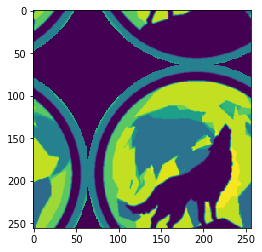

In [32]:
ind = -1
visual_specie(best_specie_gen[ind],blocks)
compute_cost(best_specie_gen[ind],blocks,num_blk_x,num_blk_y)

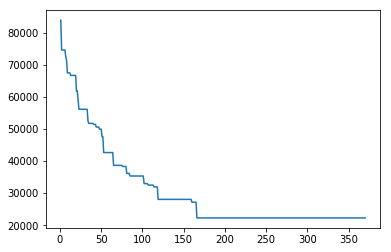

In [38]:
y = []
x = []
for i in range(len(best_specie_gen)):
    y.append(compute_cost(best_specie_gen[i],blocks,num_blk_x,num_blk_y))
    x.append(i+1)
plt.plot(x,y)

137236.0

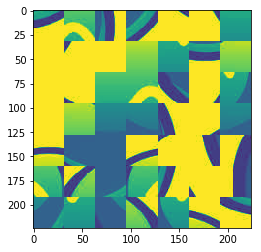

In [916]:
ind = 75
visual_specie(best_specie_gen[ind],blocks)
compute_cost(best_specie_gen[ind],blocks,num_blk_x,num_blk_y)

In [857]:
total_gen = 3000

In [792]:
print(len(best_specie_gen))

100


20960

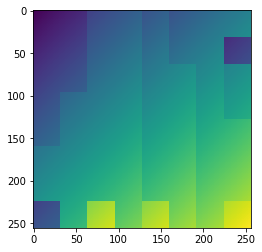

In [596]:
visual_specie(best_specie_gen[9998],blocks)
compute_cost(best_specie_gen[9998],blocks,num_blk_x,num_blk_y)

20416

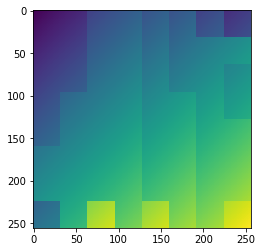

In [598]:
visual_specie(best_specie_gen[-1],blocks)
compute_cost(best_specie_gen[-1],blocks,num_blk_x,num_blk_y)

In [593]:
with open("16*16_10k-gen.pkl","wb") as f:
    pickle.dump([best_specie_gen, population, curr_gen],f)

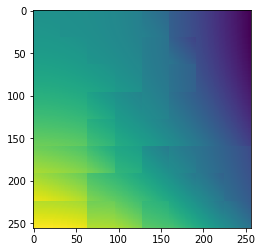

In [847]:
visual_specie(population[0],blocks)

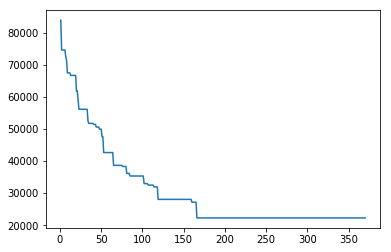